# NeuroDyn Python model

## Overview

This guide introduces the Python software environment for setting up and simulating a model of the NeuroDyn hardware equations. By the end of the guide you should get an understanding of the dynamics of a NeuroDyn neuron, be able to construct a NeuroDyn object, as well as understand how to fit the parameters of the model in order to emulate the biophysical conductance-based models.

## Setting up the environment

We first need to import the modules with the appropriate model definitions, as well as the Python packages that we will need:

- `matplotlib.pyplot`: Python plotting module
- `numpy`: Python library for numerical operations
- `cb_models`: model definitions for both standard conductance-based models as well as NeuroDyn

In [2]:
# Check if notebook is running on Google Colab
if 'google.colab' in str(get_ipython()):
  # clone the repo to get neuron models
  !git clone https://github.com/lukaribar/telluride-21.git
  import os
  os.chdir('telluride-21')

Cloning into 'telluride-21'...
remote: Enumerating objects: 267, done.
remote: Counting objects: 100% (159/159), done.
remote: Compressing objects: 100% (85/85), done.
remote: Total 267 (delta 109), reused 101 (delta 71), pack-reused 108
Receiving objects: 100% (267/267), 1.67 MiB | 21.43 MiB/s, done.
Resolving deltas: 100% (142/142), done.


In [3]:
import matplotlib.pyplot as plt
from cb_models import HHModel, NeuroDynModel

# **Ignore overflow warnings**
import numpy as np
np.seterr(all="ignore")

%matplotlib inline
%load_ext autoreload
%autoreload 2

## Hodgkin-Huxley model

We start with a short overview of the standard Hodgkin-Huxley model of squid giant axon and how we can define it using the environment.

The Hodgkin-Huxley model of the neural membrane dynamics is given by the following set of equations:

\begin{align}
C \dot{V} &= - \bar{g}_l (V - E_l) - \bar{g}_{Na} m^3 h (V - E_{Na}) - \bar{g}_K n^4 (V - E_K) + I_{app} \\
\dot{m} &= \alpha_m (V) (1 - m) - \beta_m (V) m \\
\dot{h} &= \alpha_h (V) (1 - h) - \beta_h (V) h \\
\dot{n} &= \alpha_n (V) (1 - n) - \beta_n (V) n
\end{align}


Let's start by defining a Hodgkin-Huxley model of a neuron that implements these equations - a NeuroDyn model will be done in very much the same way in the following sections.

In [4]:
hh_neuron = HHModel()

By passing no arguments to the `HHModel` class, an instance of the neuron is created with default parameters taken from the original Hodgkin-Huxley equations. Note that the values of the constants are shifted so that the resting potential is at $0 mV$. If we instead wanted to initialize a model with, for example, different sodium current parameters, we could do that as:

`hh_neuron = HHModel(gna = 100, Ena = 50)`

which would set $g_{Na} = 100 mS$ and $E_{Na} = 50 mV$.

Let's try simulating the model for which we only need to define the $I_{app}(t)$ function for the applied current. We can try different values for the magnitude of the constant current $I_0$ to showcase both resting and spiking behaviors.

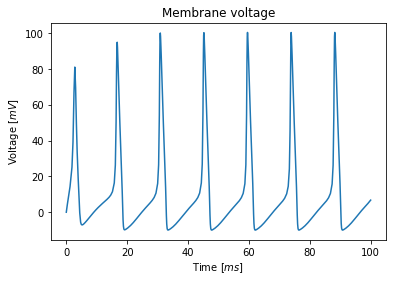

In [5]:
def Iapp(t):
    I0 = 10 # applied current in uA
    return I0

T = 100 # length of the simulation in ms
trange = (0, T)

x0 = [0,0,0,0] # initial conditions [V0, m0, h0, n0]

sol = hh_neuron.simulate(trange, x0, Iapp)

plt.figure()
plt.xlabel("Time [$ms$]")
plt.ylabel("Voltage [$mV$]")
plt.title("Membrane voltage")
plt.plot(sol.t, sol.y[0])
plt.show()

### Additional options

##### Converting units to SI

There is a few things to note here. For convenience, all of the parameters and variables are in non-SI units, so that the voltages are expressed in $mV$, currents in $\mu A$, time in $m s $, etc. If we instead wanted to convert the model to SI units, we can initialize the neuron as:

`hh_neuron = HHModel(SI_units = True)`

which will convert all parameters of the model to SI units.

##### Voltage and time scaling

A few other options that will be useful once we start defining NeuroDyn models are the parameters for scaling the time and the voltage scales of the model, `scl_t` and `scl_v`. Let's see how this works by instead defining a neuron as:

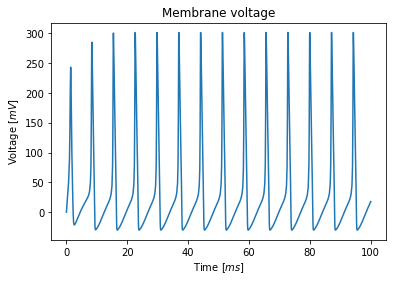

In [6]:
hh_neuron_scaled = HHModel(scl_v = 3, scl_t = 2)

def Iapp(t):
    I0 = 10 # applied current in uA
    return I0

T = 100 # length of the simulation in ms
trange = (0, T)

x0 = [0,0,0,0] # initial conditions [V0, m0, h0, n0]

sol = hh_neuron_scaled.simulate(trange, x0, Iapp)

plt.figure()
plt.xlabel("Time [$ms$]")
plt.ylabel("Voltage [$mV$]")
plt.title("Membrane voltage")
plt.plot(sol.t, sol.y[0])
plt.show()

We can try changing the values for `scl_t` and `scl_v` and see how it changes the behavior compared to the non-scaled simulation we have previously produced.

When we try fitting the conductance-based models to the NeuroDyn hardware we will see that it will be necessary to *scale* both voltage and time of the original model in order to fit them to the hardware constraints. This will change the timescale and the voltage range in which the NeuroDyn neuron operates, but importantly, will not change the underlying dynamical properties of the model.

## NeuroDyn model

### Initializing a NeuroDyn model

Creating a NeuroDyn object is done in exactly the same way as creating a Hodgkin-Huxley object by using the class `NeuroDynModel`. We can therefore create a NeuroDyn neuron using default parameters by calling:

`nd_neuron = NeuroDynModel()`

Note that NeuroDyn uses SI units for all of its parameters and variables, so that the voltage output is in $V$, time is in $s$, etc.

Before we create a NeuroDyn neuron and use it to simulate spiking behavior, let's first look at the NeuroDyn equations and how they connect to the Hodgkin-Huxley equations. The details of the section may be skipped and readers might go directly to the **Summary** that lists all of the controllable parameters and the mappings to the corresponding Hodgkin-Huxley parameters.

### NeuroDyn equations

Let's now take a look at the full list of parameters that are required to define a NeuroDyn model. NeuroDyn circuit replicates the equations of Hodgkin-Huxley in hardware, and we will now see how the different parameters map to the biophysical constants of the conductance-based models.

#### Membrane equation

Let's start with the membrane dynamics equation:

\begin{align}
C_{ND} \dot{V} &= -I_l - I_{Na} - I_K + I_{app}\\
 &= - 2 I_{g_l} \tanh \bigg( \frac{\kappa_{lin} (V - E_l)}{2 V_T} \bigg) - 2 I_{g_{Na}} \tanh \bigg( \frac{\kappa_{lin} (V - E_{Na})}{2 V_T} \bigg) - 2 I_{g_{K}} \tanh \bigg( \frac{\kappa_{lin} (V - E_K)}{2 V_T} \bigg)
\end{align}

HH equations again, for reference:
\begin{align}
C \dot{V} &= - \bar{g}_l (V - E_l) - \bar{g}_{Na} m^3 h (V - E_{Na}) - \bar{g}_K n^4 (V - E_K) + I_{app} \\
\dot{m} &= \alpha_m (V) (1 - m) - \beta_m (V) m \\
\dot{h} &= \alpha_h (V) (1 - h) - \beta_h (V) h \\
\dot{n} &= \alpha_n (V) (1 - n) - \beta_n (V) n
\end{align}

Note that capacitance of NeuroDyn $C_{ND} = 4 pF$ is significantly smaller than the capacitance of Hodgkin-Huxley $C_{HH} = 1 \mu F$ which we will need to take into consideration when setting the other parameters of the circuit. 

The nonlinear $\tanh$ relationship comes from the transconductance amplifier characteristic that implements the individual conductance relatinships. These amplifiers have additional circuitry to linearize this relationship which makes the constant $\kappa_{lin}$ small. In the simulation, we set $\kappa_{lin} = 0.2$. The constant $V_T$ is the temperature-dependent thermal voltage and is assumed to be $V_T \approx 26 mV$.

##### Maximal conductances

Assuming the conductance circuit is in the linear range so that $\tanh{x} \approx x$, we can define the relationship between the circuit parameters and the original Hodgkin-Huxley equation by comparing the two directly:

\begin{equation}
g_l = \frac{\kappa_{lin}}{V_T} I_{g_l}, \quad
g_{Na} = \frac{\kappa_{lin}}{V_T} I_{g_{Na}}, \quad
g_{K} = \frac{\kappa_{lin}}{V_T} I_{g_{K}}
\end{equation}

It is clear from these equations that the conductances $g_l$, $g_{Na}$ and $g_K$ are effectively represented by three currents in the circuit $I_{g_l}$, $I_{g_{Na}}$ and $I_{g_K}$. The current $I_{g_l}$ is constant, reflecting the static nature of the leak current, while currents $I_{g_{Na}}$ and $I_{g_K}$ have the dynamics replicating the ion channel opening and closing processes.

##### Reversal potentials

The reversal potentials $E_l$, $E_{Na}$ and $E_K$ are defined using digital values using the following equation:

\begin{equation}
E_{rev} = I_{voltage} \cdot \frac{dE_{rev}}{1024} \cdot sign \cdot R_{rev} + V_{ref}
\end{equation}

The current $I_{voltage}$ is controllable and is shared by all the variables in the circuit. Similarly, $V_{ref}$ is controllable and is shared by all the circuits - it effectively shifts all of the parameters in the voltage range. The resistor $R_{rev} = 1.63 M\Omega$ is fixed.

#### Ion currents

Let's now look at the dynamics for the currents $I_{g_{Na}}$ and $I_{g_K}$:

\begin{align}
I_{g_{Na}} &= I_{\bar{g}_{Na}} \bigg(\frac{I_m}{I_{ref}} \bigg)^3 \bigg(\frac{I_h}{I_{ref}} \bigg)\\
I_{g_K} &= I_{\bar{g}_{K}} \bigg(\frac{I_n}{I_{ref}} \bigg)^4
\end{align}

Comparing to the equations of Hodgkin-Huxley, it is clear that the relationship between gating variables and currents is simply:

\begin{equation}
m = \frac{I_m}{I_{ref}}, \quad
h = \frac{I_h}{I_{ref}}, \quad
n = \frac{I_n}{I_{ref}}
\end{equation}

The currents determining the maximal conductance parameters are set by digital values $dg$ that set the currents between $0$ and the current $I_{master}$:

\begin{equation}
I_{\bar{g}} = I_{master} \frac{dg}{1024}
\end{equation}

#### Gating variables

Let's now take a look at the gating variable equations. The dynamical equations for the gating currents are given by:

\begin{align}
\frac{d}{dt} \bigg( \frac{I_m}{I_{ref}} \bigg) &= \frac{I_{\alpha_m}}{C_g V_T} \bigg(1 - \frac{I_m}{I_{ref}} \bigg) - \frac{I_{\beta_m}}{C_g V_T} \bigg( \frac{I_m}{I_{ref}} \bigg) \\
\frac{d}{dt} \bigg( \frac{I_h}{I_{ref}} \bigg) &= \frac{I_{\alpha_h}}{C_g V_T} \bigg(1 - \frac{I_h}{I_{ref}} \bigg) - \frac{I_{\beta_h}}{C_g V_T} \bigg( \frac{I_h}{I_{ref}} \bigg) \\
\frac{d}{dt} \bigg( \frac{I_n}{I_{ref}} \bigg) &= \frac{I_{\alpha_n}}{C_g V_T} \bigg(1 - \frac{I_n}{I_{ref}} \bigg) - \frac{I_{\beta_n}}{C_g V_T} \bigg( \frac{I_n}{I_{ref}} \bigg)
\end{align}

Comparing again to the original Hodgkin-Huxley equations, we see that a simple substitution relates $I_{\alpha}$ and $I_{\beta}$ with $\alpha (V)$ and $\beta (V)$ for each gating variable $m$, $h$ and $n$:

\begin{equation}
\alpha (V) = \frac{I_{\alpha} (V)}{C_g V_T}, \quad
\beta(V) = \frac{I_{\beta} (V)}{C_g V_T}
\end{equation}

The constant $V_T$ is the same thermal voltage defined previously, while the capacitance used in the gating variable equations $C_g = 5 p F$ is different from the membrane capacitance $C_{ND}$.


So far, we have seen that there is a one-to-one correspondence between the physical parameters of NeuroDyn and the Hodgkin-Huxley parameters. Let's now see how we can shape the $\alpha(V)$ and $\beta(V)$ functions in NeuroDyn by designing the corresponding currents $I_{\alpha}$ and $I_{\beta}$.

#### Designing $\alpha (V)$ and $\beta (V)$ functions

Each current $I_{\alpha}$ and $I_{\beta}$ is built as a summation of **seven** sigmoidal IV currents, so that by changing the weights of these seven sigmoids we are able to fit the parameters to different $\alpha (V)$ and $\beta (V)$ functions. Therefore, the currents $I_{\alpha}$ and $I_{\beta}$ for each gating variable are represented by:

\begin{align}
I_{\alpha} &= \sum_{j=1}^7 \frac{I_{\alpha, j}}{1 + \exp{\big( sign \cdot \kappa \cdot (V_{b,j} - V)} \big)} \\
I_{\beta} &= \sum_{j=1}^7 \frac{I_{\beta, j}}{1 + \exp{\big( sign \cdot \kappa \cdot (V_{b,j} - V)} \big)}
\end{align}

The process-dependent constant $\kappa \approx 0.7$ is constant throughout the circuit. Note that this is different from $\kappa_{lin}$ that was encountered in the membrane equation, where the constant is decreased in order to increase the linear range of the $\tanh$ nonlinearity. 

Importantly, note that all sigmoids in the summation have a $sign$ parameter that is either $+1$ or $-1$ . This is because $\alpha(V)$ and $\beta(V)$ are either monotonically increasing or decreasing functions - a monotonically increasing function will be built as a summation of monotonically increasing sigmoids, and vice-versa, a monotonically decreasing function will be built as a summation of monotonically decreasing sigmoids. So for example, the gating variable $m$ is an activating variable, so its $\alpha(V)$ function is monotonically increasing, while the gating variable $h$ is an inactivating variable, and so its $\alpha(V)$ function is instead monotonically decreasing.

The sigmoid placements $V_{b,j}$ are equally spaced and shared by all currents in the NeuroDyn chip, and can be controlled by the current $I_{voltage}$.

Each of the sigmoid weights $I_{\alpha, j}$ and $I_{\beta, j}$ are set by digital values in the same way as we have defined previously for maximal conductance currents:

\begin{align}
I_{\alpha, j} &= I_{master} \frac{dI_{\alpha,j}}{1024} \\ 
I_{\beta, j} &= I_{master} \frac{dI_{\beta,j}}{1024}
\end{align}

### Summary of the parameters

The parameters that can be passed to the NeuroDyn class are the following:

- `dg = [dgna, dgk, dgl]`: digital values for maximal conductances $\bar{g}_{Na}$, $\bar{g}_{K}$ and $\bar{g}_l$
- `dErev = [dEna, dEk, dEl]`: digital values for reversal potentials $E_{Na}$, $E_K$ and $E_l$
- `dIb = [dIb_m, dIb_h, dIb_n]`: digital values for the weights of the spline functions
    - each `dIb_m` `dIb_h` and `dIb_n` is an array consisting of `[dIb_alpha, dIb_beta]`
    - each `dIb_alpha` and `dIb_beta` is an array of 7 digital values for the spline coefficients
- `V_ref`: analog reference voltage (shifts all voltage values to be around $V_{ref}$)
- `I_voltage`: analog current determining the range of reversal potentials, as well as spline positions
- `I_master`: analog current determining the range of maximal conductances, as well as spline weights
- `I_ref`: reference current for gating variables
    - **Note**: the current has no effect on the model equations, but is a controllable parameter in the chip
- `capacitance_scaling`: additional scaling factor that multiplies the membrane capacitance of the model
    - **Note**: by default, the scaling factor is $1.0$, and the membrane capacitance is set to $4 pF$
    - Setting `capacitance_scaling = 0.1` for instance would set the membrane capacitance to $0.4 pF$
    
Note that the currents `I_voltage`, `I_master` and `I_ref` are directly passed in the simulation, while in the chip we control these currents with corresponding voltage values. All digital values are integers between $0$ and $1023$.

### Fitting the equations

Let's now see how we can fit the parameters of the NeuroDyn model so that it replicates the behavior of a conductance-based model of a neuron. For this we will use the `fitting_utilities` module.

In [7]:
from fitting_utilities import FitND

The class `FitND` takes a single `HHModel` object at the initialization, defining the conductance-based neuron we would like to fit to.

We can also pass additional arguments that are otherwise set to their default values:
- `I_master`: the $I_{master}$ current that we have set for the NeuroDyn model. Default value is $150 nA$.
- `I_voltage`: the $I_{voltage}$ current that we have set for the NeuroDyn model. Default value is $200 nA$.
- `capacitance_scaling`: capacitance scaling for the NeuroDyn model we will use. Default values is $1$.
- `vrange`: numpy array of voltage points at which we evaluate the fitting. Default is `np.arange(Ek, Ena/2, 5e-4).T`.

Let's first try to pass a regular Hodgkin-Huxley neuron to the fitting class:

In [8]:
hh_neuron = HHModel(SI_units = True)

fit_obj = FitND(hh_neuron)

Note that we have set `SI_units = True` - this is important as all of the NeuroDyn values are defined in SI units, so we would like to first convert our original model to SI units before we continue fitting.

If we now call the method `fitHH` of the class, the code will conduct a non-negative least squares fit in order to find the right sigmoid weights $I_{b,j}$ to fit the gating variables of the Hodgkin-Huxley model. The fitting first tries to find the optimal *analog* values for these currents, and then converts them to digital values based on the quantization discussed previously.

We can pass optinal keyword arguments to the `fitHH` function that are by default set to `False`:

- `plot_alpha_beta = True`: Plot the comparison of the original $\alpha(V)$ and $\beta(V)$ functions to the fitting results
- `plot_tau_inf = True`: Plot the comparison of the original $\tau(V)$ and $m_{\infty}(V)$ functions to the fitting results

Let's see how this works:

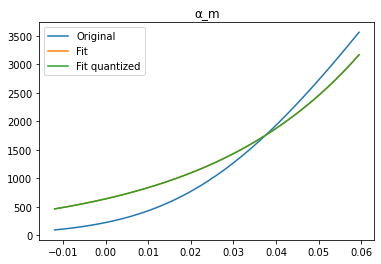

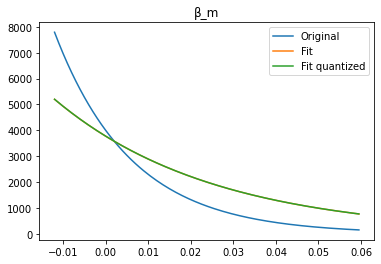

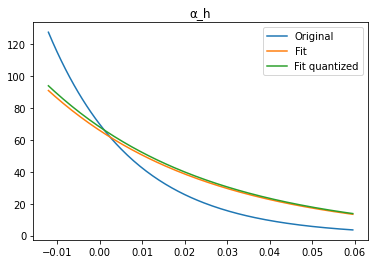

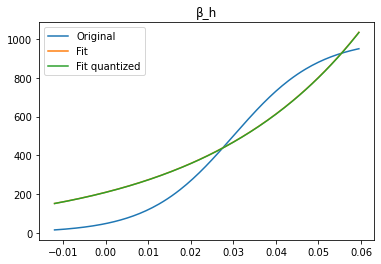

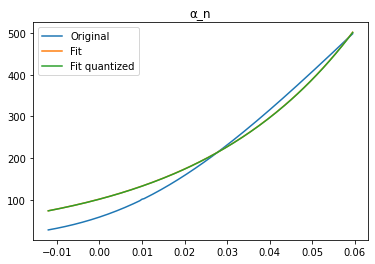

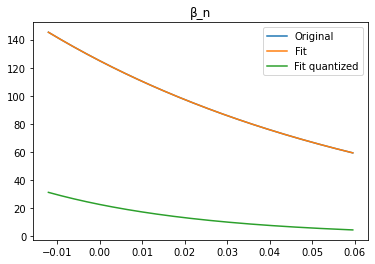

In [9]:
weights = fit_obj.fitHH(plot_alpha_beta=True) # weights stores the sigmoid coefficients

We can see that the fits do not look very good initially.

Firstly, it seems that the slopes of the sigmoids are too gentle to capture the steeper slopes of the $\alpha(V)$ and $\beta(V)$ functions, which we observe by comparing the blue and the orange curves. As the slopes of the sigmoid functions are fixed by the physical implementations, we can instead change the slopes of the Hodgkin-Huxley model instead! By changing the `scl_v` parameter of the Hodgkin-Huxley model, we can stretch the voltage range so that our sigmoids fit better to the stretched $\alpha(V)$ and $\beta(V)$ functions. This will effectively render the spikes of the NeuroDyn model larger.

Secondly, we can see that there is a significant discrepancy between the orange line (continuous fit) and the green line (fit after quantization). This happens when the current coefficients are to small to be captured by our quantization range - remember that the smallest current that NeuroDyn can output here is

\begin{equation}
\Delta I_b = \frac{I_{master}}{1024}
\end{equation}

so that if the currents returned by the fitting procedure are smaller than this, they will be set to $0$.

#### Changing the voltage scaling

Let's now try instead to fit the NeuroDyn model to a *scaled* version of the Hodgkin-Huxley object.

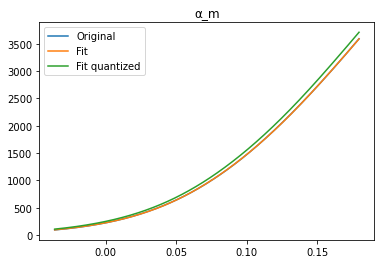

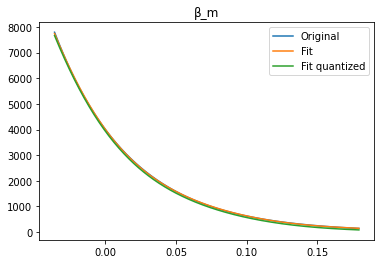

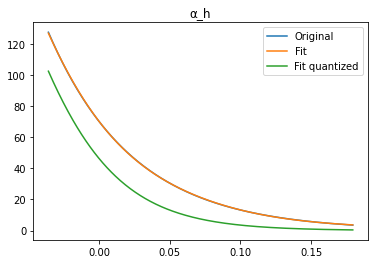

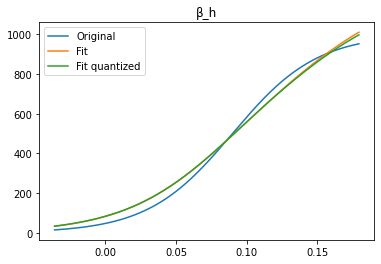

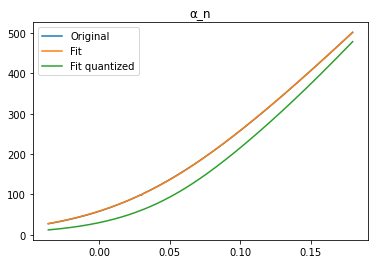

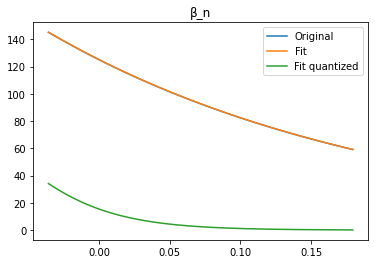

In [10]:
scl_v = 3 # voltage scaling

hh_neuron = HHModel(scl_v = scl_v, SI_units = True)

fit_obj = FitND(hh_neuron)

weights = fit_obj.fitHH(plot_alpha_beta = True)

The results now look better.

Still, we can see in the plot for $\beta_n(V)$ that the currents are too small to be captured by the quantization. In order to improve the quantized results, we can try manually increasing the coefficients corresponding to the function $\beta_n(V)$.

You can also try changing the fitting parameters to see how they affect the procedure. The parameters that have the most effect are `I_voltage` as it controls the spread of the sigmoids in the voltage range, as well as `scl_v` as it effectively changes the relative slope of the sigmoids.

#### Scaling the time

We need to determine what is the appropriate `scl_t` for the Hodgkin-Huxley model that will allow us to emulate it in hardware.

First, let's address the fact that the capacitance of $C_{ND}$ is different from the capacitance of Hodgkin-Huxley $C_{HH}$. Looking at the membrane voltage equation of Hodgkin-Huxley, we can see that we can keep the dynamics intact if we multiple both sides of the equation by the appropriate constant so that on the left we have the capacitance of the NeuroDyn circuit. This gives the corresponding NeuroDyn maximal conductances and the applied current:

\begin{align}
\bar{g}^{(ND)} &= \bar{g}^{(HH)} \cdot \frac{C_{ND}}{C_{HH}} \\
I_{app}^{(ND)} &= I_{app}^{(HH)} \cdot \frac{C_{ND}}{C_{HH}}
\end{align}

This effectively means that we need to decrease the conductances and the applied current of the NeuroDyn circuit to adjust for the difference in membrane capacitance.

We now need to ensure that the required parameter values are realizable within the hardware constraints. Remember that the $I_{master}$ current in the NeuroDyn chip effectively sets the range of possible values for the maximal conductance values $\bar{g}$ as well as the sigmoid weights $I_b$.

After we have scaled the maximal conductances appropriately, and have received the analog values for the bias currents $I_b$ from the fitting procedure, we need to make sure that all current values are within the range $(0, I_{master})$. If not, we need to scale all currents so that the maximal value fits into this range, effectively determining the constant `scl_t`.

This procedure is done automatically when we call the `fitHH` method!

#### Getting the parameters

The previous procedure of finding the right time scaling is done automatically by the quantization method in the fitting module. The quantization takes into account the maximum value of the maximal conductance parameter we would like to fit to, as well as the value of the maximal sigmoid weight, and scales the time scale so that the parameters fit within the NeuroDyn physical range.

Let's now obtain the digital parameters that we can then pass to our NeuroDyn class. For this, we can use the methods `get_digital_Ib(weights)`, `get_digital_g(g)` and `get_digital_E(E)` that will give us the digital values for the sigmoid weights, maximal conductances, and reversal potentials, respectively. The values will be automatically scaled, taking into account the `scl_v` parameter of the Hodgkin-Huxley model passed at the initialization, as well as the time scaling `scl_t` necessary for all the parameters to fit within the physical range.

In [11]:
g0 = [120e-3,36e-3,0.3e-3] # maximal conductances
E0 = [120e-3,-12e-3,10.6e-3] # reversal potentials
dIb = fit_obj.get_digital_Ib(weights)
dg = fit_obj.get_digital_g(g0)
dE = fit_obj.get_digital_E(E0)

I_master = fit_obj.I_master
I_voltage = fit_obj.I_voltage

# Manually increase coefficients if too low after fitting
dIb[2][1] = dIb[2][1]*15

scl_t = fit_obj.get_scl_t()
print("The time scaling scl_t is", scl_t) 

#%% Print the parameter values
print('\nImaster = ', I_master)
print('Ivoltage = ', I_voltage)

print('\nDigital values for maximal conductances:')
print('[gna, gk, gl] = ', dg, '\n')

print('Digital values for reversal potentials:')
print('[Ena, Ek, El] = ', dE, '\n')

print('Digital values for gating variable kinetics:')
print('alpha_m = ', dIb[0][0])
print('beta_m = ', dIb[0][1], '\n')
print('alpha_h = ', dIb[1][0])
print('beta_h = ', dIb[1][1], '\n')
print('alpha_n = ', dIb[2][0])
print('beta_n = ', dIb[2][1], '\n')

The time scaling scl_t is 11.206993689903845

Imaster =  2e-07
Ivoltage =  1.5e-07

Digital values for maximal conductances:
[gna, gk, gl] =  [1023.  307.    3.] 

Digital values for reversal potentials:
[Ena, Ek, El] =  [ 829. -829. -545.] 

Digital values for gating variable kinetics:
alpha_m =  [  0.   1.  11.  23.   0.   0. 870.]
beta_m =  [190.   4.   6.   0.   0.   0.   0.] 

alpha_h =  [3. 0. 0. 0. 0. 0. 0.]
beta_h =  [0. 0. 6. 3. 0. 0. 0.] 

alpha_n =  [0. 0. 2. 2. 3. 0. 0.]
beta_n =  [15.  0.  0.  0.  0.  0.  0.] 



### Simulating the fitted model

Let's now try to use the parameters we have just calculated in order to define a new NeuroDyn object:

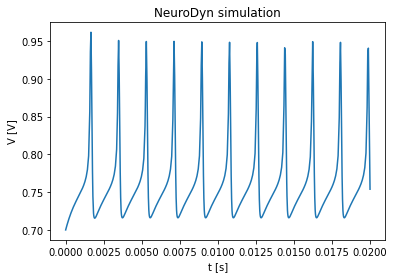

In [12]:
I0 = 0e-6 # current in the original Hodgkin-Huxley model
Iapp = lambda t : fit_obj.convert_I(I0) # scale the current based on scl_t, scl_v and C_HH/C_ND

V_ref = 0.9

ND = NeuroDynModel(dg, dE, dIb, V_ref, I_voltage, I_master)

T = 0.02
trange = (0, T)

sol = ND.simulate(trange,[0.7,0,0,0],Iapp)

plt.figure()
plt.xlabel('t [s]')
plt.ylabel('V [V]')
plt.title('NeuroDyn simulation')
plt.plot(sol.t, sol.y[0])
plt.show()

We can compare this to the scaled Hodgkin-Huxley model:

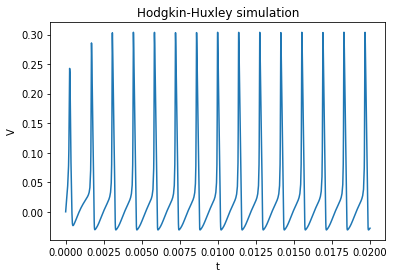

In [13]:
hh_neuron = HHModel(scl_v = 3, scl_t = scl_t, SI_units = True)

I0 = 8e-6
Iapp = lambda t: I0

T = 0.02
trange = (0, T)

sol = hh_neuron.simulate(trange,[0,0,0,0],Iapp)

plt.figure()
plt.xlabel('t')
plt.ylabel('V')
plt.title('Hodgkin-Huxley simulation')
plt.plot(sol.t, sol.y[0])
plt.show()

### Passing analog values to NeuroDyn

Instead of passing the digital parameter values `dg`, `dErev` and `dIb` we can also see how the NeuroDyn circuit would behave with the exact analog values obtained through the fitting process. This can allow us to get a better understanding of how the quantization error affects the circuit behavior.

This can be easily done by passing a keyword argument `digital_values = False` when creating a NeuroDyn object. The object in this case expects analog values to be passed to `dg`, `dErev` and `dIb` variables instead of the standard integers between $0$ and $1023$.

In order to get the analog values, we can call the corresponding `get_analog_Ib(weights)`, `get_analog_g(g)` and `get_analog_E(E)` instead of the digital methods that we have used previously.

Let's see how this works using the results from our previous fitting procedure:

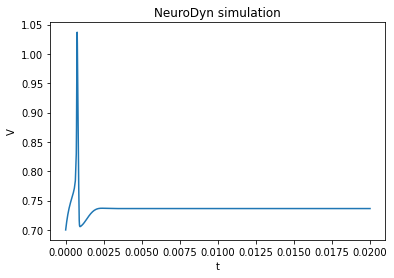

In [14]:
Ib = fit_obj.get_analog_Ib(weights)
g = fit_obj.get_analog_g(g0)
E = fit_obj.get_analog_E(E0)

ND_analog = NeuroDynModel(g, E, Ib, V_ref, I_voltage, I_master, digital_values = False)

I0 = 0e-6 # current in the original Hodgkin-Huxley model
Iapp = lambda t : fit_obj.convert_I(I0) # scale the current based on scl_t and C_HH/C_ND

T = 0.02
trange = (0, T)

sol = ND_analog.simulate(trange,[0.7,0,0,0],Iapp)

plt.figure()
plt.xlabel('t')
plt.ylabel('V')
plt.title('NeuroDyn simulation')
plt.plot(sol.t, sol.y[0])
plt.show()

You may notice in this case that even by increasing the applied current to the neuron, the circuit does not start regularly spiking. The main source of discrepancy that is left here is the non-linearity of the conductance relationship involving the $\tanh$ input-output relationship. This non-linearity means that the same conductance values will lead to a somewhat different behavior for the same parameters, as observed by the lack of regular spiking here. Still, slight changes to the values may fix this - in this case, we can decrease the potassium conductance to *increase* the excitability of the neuron.

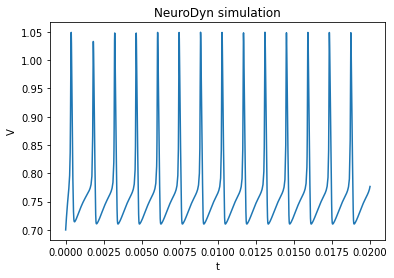

In [15]:
g[1] = 0.6*g[1] # decrease potassium conductance

ND_analog = NeuroDynModel(g, E, Ib, V_ref, I_voltage, I_master, digital_values = False)

I0 = 7e-6 # current in the original Hodgkin-Huxley model
Iapp = lambda t : fit_obj.convert_I(I0) # scale the current based on scl_t and C_HH/C_ND

T = 0.02
trange = (0, T)

sol = ND_analog.simulate(trange,[0.7,0,0,0],Iapp)

plt.figure()
plt.xlabel('t')
plt.ylabel('V')
plt.title('NeuroDyn simulation')
plt.plot(sol.t, sol.y[0])
plt.show()

## Modelling variability

The model we have introduced in the previous sections of course presents an idealized picture compared to the physical realization in hardware. The difference stems from the inherent noise and variability present in electrical circuits, which is especially true for subthreshold analog techniques that we are utilizing within NeuroDyn. Due to this effect, setting the same set of external parameters to different NeuroDyn chips will yield different behavior and appropriate compensation techniques will need to be applied to tackle the variability.

The basic source of variability is the *transistor mismatch*: applying the same gate voltage to different transistors within the circuit will generate different drain currents. We can model this variability in a simple way, by considering that these currents will obey a Gaussian distribution:

\begin{equation}
I_{out} = I_0 \cdot (1 + \mathcal{N}(0, \sigma^2))
\end{equation}

where $I_0$ is the nominal output current and $\mathcal{N}$ is a Gaussian distribution with the standard deviation $\sigma$. A rule of thumb that we use here is to set $\sigma \approx 0.15$, which is the default value in the model.

### Perturb function

We can apply the transistor current variability to our NeuroDyn model by calling the function `perturb(sigma)`. This function will apply the Gaussian distribution variability to the main parameters affected: maximal conductances, reversal potentials, sigmoid weights of the $\alpha(V)$ and $\beta(V)$ functions and the gating variable exponents (e.g. $4$ in $m^4$ for the sodium current).

Let's see how our previously defined model behaves after we add the variability (make sure you ran the previous code where we defined the initial digital NeuroDyn model):

In [ ]:
I0 = 0e-6
Iapp = lambda t : fit_obj.convert_I(I0)

ND.perturb() # leaving out the keyword argument sets default sigma = 0.15

sol = ND.simulate(trange,[0.7,0,0,0],Iapp)

plt.figure()
plt.xlabel('t')
plt.ylabel('V')
plt.title('Perturbed NeuroDyn simulation')
plt.plot(sol.t, sol.y[0])
plt.show()

We can rerun this code multiple times and see how each instance behaves. You should notice that each time we generate an instance of the neuron the behavior changes - the spike frequency and height may change, and sometimes we do not get spiking at all!

You can try compensating for this by changing some parameters of the model to make the neuron excitable again. For example, maybe due to the perturbation the threshold voltage has increased and a simple increase in the applied current can get it back to spiking. Alternatively we may need to increase the maximal conductance of the sodium current relative to the maximal conductance of the potassium current in order to increase the excitability of the model. Sometimes though the perturbation might just be too large for these simple techniques to work!

Let's try this out. First, let's check the current values of these parameters:

In [ ]:
print("The current value of applied current is ", I0)
print("The current values for the maximal conductances are", dg)

Now let's see if our simple compensation technique can work:

In [ ]:
# First try changing the applied current
I0 = 0e-6
Iapp = lambda t : fit_obj.convert_I(I0)

# If changing applied current didn't help, try adjusting the maximal conductances
# dg = [1023, 307, 3]
dg_comp = np.array([1023, 307, 3])
ND.update_dg(dg_comp)

sol = ND.simulate(trange,[0.7,0,0,0],Iapp)

plt.figure()
plt.xlabel('t')
plt.ylabel('V')
plt.title('Compensated NeuroDyn simulation')
plt.plot(sol.t, sol.y[0])
plt.show()

You can try changing other parameters as well and get a feel for how hard it is to compensate for the internal mismatch -  this inherent variability is common to both biological neurons and neuromorphic circuits and is the main challenge to designing and controlling bioinspired circuits.